# Prospecção de Dados (Data Mining) DI/FCUL - HA2

## Second Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP:`13`

* Miguel Landum, 35019 - Hours worked on the project
* Niklas Schmitz, 62689 - Hours worked on the project
* Pol Parra, 62692 - Hours worked on the project
* Til Dietrich, 62928 - Hours worked on the project


## Objectives
The purpose of this Home Assignment is:

1. Analyze the itemset/rules generation procedure
2. Process and identify the most relevant rules

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**


### 1. Read the Dataset

Dataset: Instacart [Market Basket Analysis](https://www.kaggle.com/datasets/psparks/instacart-market-basket-analysis)



The purpose of this Home Assignment is:

1. Analyze the itemset/rules generation procedure
2. Identify the most relevant rules

Please download the HA files from this moodle folder and inspect it like this:
**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

The dataset has been preprocessed with transactions as lists of integers. It is necessary a decoder to see the actual products bought together

Uncompress the data set (zip file) which will produce 2 files:
* `order_products.pickle` a Python pickle with all the trasactions
* A `products.txt` - decoder table with all the data relative to each item



**Important:** As the order products pickle file is larger than 100MB and therefore can't be uploaded to git, it is necessary to have the pickle file locally in the data folder: assignment-2/data/order_products__local.pickle. This file is included in .gitignore

In [6]:
#Read product names and IDs
lines=open("data/products.txt", "rt", encoding="utf8").readlines()
products=[0]*len(lines)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid)]=pname
    
#read transactions
import pickle
orders=pickle.load(open("data/order_products__local.pickle", "rb"))

#check names of products on transaction 2 (example):
print("Transaction 2 is", orders[2])
for prod in orders[2]: print("Code: %5d is product: %s" %(prod, products[prod]))

Transaction 2 is [33120, 28985, 9327, 45918, 30035, 17794, 40141, 1819, 43668]
Code: 33120 is product: Organic Egg Whites
Code: 28985 is product: Michigan Organic Kale
Code:  9327 is product: Garlic Powder
Code: 45918 is product: Coconut Butter
Code: 30035 is product: Natural Sweetener
Code: 17794 is product: Carrots
Code: 40141 is product: Original Unflavored Gelatine Mix
Code:  1819 is product: All Natural No Stir Creamy Almond Butter
Code: 43668 is product: Classic Blend Cole Slaw


### Objective 1 - Analyze the itemset/rules generation procedure

1. From the approaches used in classes make a performance analysis up to a threshold level of support
2. Define a good support threshold for analysis according to your computational capabilities


In [7]:
### Add supporting functions here
# imports
import numpy as np
import pandas as pd
import random
from mlxtend.preprocessing import  TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth
from pyfim import pyeclat

import matplotlib.pyplot as plt

import time

# Functions

# Function to extract product names from lines
def extract_product_names(lines):
    # Initialize an empty dictionary to store product IDs and names
    products = {}
    
    # Iterate over the lines, skipping the first one (usually headers)
    for line in lines[1:]:
        # Split each line into components and strip any leading/trailing whitespace
        pid, pname, aid, did = line.strip().split("\t")
        
        # Add the product ID (converted to integer) and name to the dictionary
        products[int(pid)] = pname
    
    return products

# Function to replace product codes with product names
def replace_product_codes_with_names(orders, products):
    # Create dictionary
    orders_with_names = {}

    # Loop over transactions
    for transaction_id, product_codes in orders.items():
        # Replace product codes with product names and store
        product_names = [products[code] for code in product_codes]
        orders_with_names[transaction_id] = product_names

    # Transform to list for further use
    orders_with_names_list = list(orders_with_names.values())

    return orders_with_names_list

# Function to compute binary database (transactions X products)
def create_binary_database(transactions):
    # Initialize the TransactionEncoder
    tr_enc = TransactionEncoder()
    
    # Fit the encoder on the transactions and transform the data
    trans_array = tr_enc.fit_transform(transactions)
    
    # Create a binary dataframe with appropriate column headers (product names)
    binary_database = pd.DataFrame(trans_array, columns=tr_enc.columns_)
    
    return binary_database

# Function for comparing the performance of different algorithms
def compare_algorithm_performance(D, binary_database_subset, subset_orders_with_names_list, algorithms):
    for algorithm in algorithms:
        D[algorithm + "_itemsets"] = []
        
    for min_supp in D["threshold"]:
        for algorithm in algorithms:
            #print(f"Running {algorithm} with support {min_supp}")  # Debug print
            if algorithm == "apriori":
                t0 = time.time()
                FI_apriori = apriori(binary_database_subset, min_support=min_supp, use_colnames=True)
                t1 = time.time()
                D["apriori"].append(t1 - t0)
                D["apriori_itemsets"].append(len(FI_apriori))
            
            elif algorithm == "fpgrowth":
                t0 = time.time()
                FI_fpg = fpgrowth(binary_database_subset, min_support=min_supp, use_colnames=True)
                t1 = time.time()
                D["fpgrowth"].append(t1 - t0)
                D["fpgrowth_itemsets"].append(len(FI_fpg))
            
            elif algorithm.lower() == "eclat":
                t0 = time.time()
                FI_eclat = pyeclat(subset_orders_with_names_list, min_supp)
                t1 = time.time()
                D["ECLAT"].append(t1 - t0)
                D["ECLAT_itemsets"].append(len(FI_eclat))

    df_performance = pd.DataFrame(D)
    return df_performance


Finished replacing product codes with names


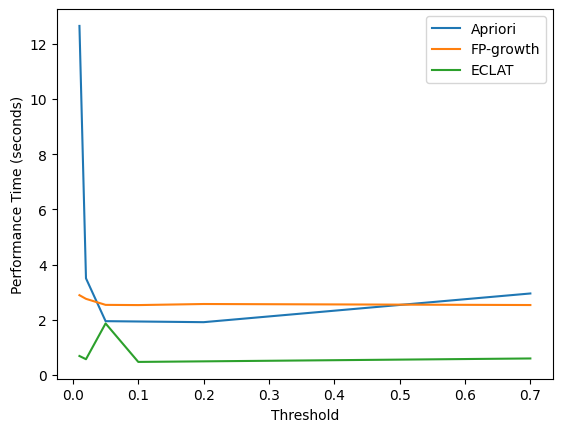

,threshold,apriori,fpgrowth,ECLAT,apriori_itemsets,fpgrowth_itemsets,ECLAT_itemsets
0,0.70,2.953186,2.534213,0.597015,0,0,0
1,0.20,1.912774,2.571201,0.492409,0,0,0
2,0.10,1.937293,2.532374,0.471662,2,2,2
3,0.05,1.949477,2.539960,1.866803,6,6,6
4,0.02,3.502638,2.758801,0.569890,41,41,41
5,0.01,12.653302,2.890734,0.686594,117,117,117


Finished computing and displaying performance for partial dataset


,support,itemsets,Algorithm,Support Threshold
0,0.03264,(Organic Zucchini),FP-Growth,0.01
1,0.01008,(Feta Cheese Crumbles),FP-Growth,0.01
2,0.07397,(Organic Baby Spinach),FP-Growth,0.01
3,0.05387,(Organic Avocado),FP-Growth,0.01
4,0.03426,(Organic Garlic),FP-Growth,0.01
...,...,...,...,...
346,0.01308,"(Banana, Strawberries)",Apriori,0.01
347,0.01148,"(Organic Baby Spinach, Organic Hass Avocado)",Apriori,0.01
348,0.01191,"(Organic Strawberries, Organic Baby Spinach)",Apriori,0.01
349,0.01339,"(Organic Strawberries, Organic Hass Avocado)",Apriori,0.01


Finished computing and displaying frequent itemsets for small partial dataset


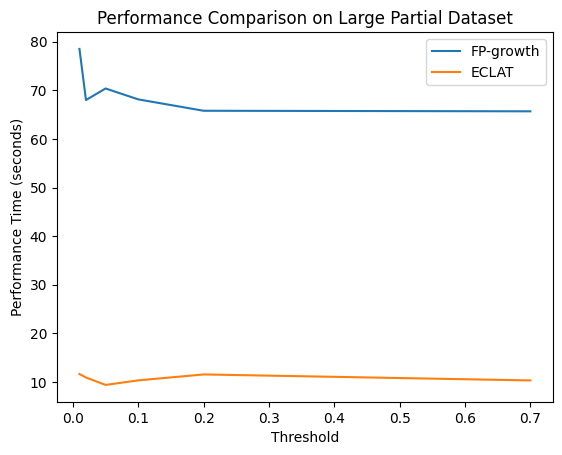

,threshold,fpgrowth,ECLAT,fpgrowth_itemsets,ECLAT_itemsets
0,0.70,65.686697,10.291788,0,0
1,0.20,65.801037,11.525385,0,0
2,0.10,68.142828,10.307028,2,2
3,0.05,70.385953,9.367505,6,6
4,0.02,68.007361,10.890246,40,40
5,0.01,78.530277,11.616368,117,117


Finished computing and displaying performance for large partial dataset


In [8]:
### Add processing code here
# General params
random.seed(420)
subset_size_small = 100000
subset_size_large = 1000000

# Get product names and replace product codes in transactions with names
products = extract_product_names(lines)
orders_with_names_list = replace_product_codes_with_names(orders, products)
print("Finished replacing product codes with names")

# Since the dataset is too big we do a random sample
subset_orders_with_names_list = random.sample(orders_with_names_list, subset_size_small)

# Compute binary database
binary_database_subset = create_binary_database(subset_orders_with_names_list)

# Apriori, FP-Growth, and Eclat algorithms used for association rule mining in data mining are used to find frequent itemsets in the dataset
# Set-up dict for performance comparison
D = {"threshold": [0.7, 0.2, 0.1, 0.05, 0.02, 0.01],
     "apriori": [],
     "fpgrowth": [],
     "ECLAT": []
     }

# Set-up list of algorithms
algorithms = ["apriori", "fpgrowth", "ECLAT"]

df_performance = compare_algorithm_performance(D, binary_database_subset, subset_orders_with_names_list, algorithms)

plt.plot(df_performance["threshold"], df_performance["apriori"], label="Apriori")
plt.plot(df_performance["threshold"], df_performance["fpgrowth"], label="FP-growth")
plt.plot(df_performance["threshold"], df_performance["ECLAT"], label="ECLAT")
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Performance Time (seconds)')
plt.show()

# Display performance DataFrame
display(df_performance)

print("Finished computing and displaying performance for partial dataset")

# Generate frequent itemsets
FI_fpg = fpgrowth(binary_database_subset, 0.01, use_colnames=True)
FI_eclat = pyeclat(subset_orders_with_names_list, 0.01) 
FI_apriori = apriori(binary_database_subset, 0.01, use_colnames=True)  

FI_fpg['Algorithm'] = 'FP-Growth'
FI_fpg['Support Threshold'] = 0.01
FI_eclat['Algorithm'] = 'ECLAT'
FI_eclat['Support Threshold'] = 0.01
FI_apriori['Algorithm'] = 'Apriori'  
FI_apriori['Support Threshold'] = 0.01

combined_df = pd.concat([FI_fpg, FI_eclat, FI_apriori])

combined_df.reset_index(drop=True, inplace=True)

display(combined_df)

print("Finished computing and displaying frequent itemsets for small partial dataset")

# ----------------------------
# Run FP-growth and ECLAT with different thresholds on larger dataset
large_subset_orders_with_names_list = random.sample(orders_with_names_list, subset_size_large)
binary_database_large = create_binary_database(large_subset_orders_with_names_list)

# Setup dictionary for performance comparison
D = {"threshold": [0.7, 0.2, 0.1, 0.05, 0.02, 0.01],
     "fpgrowth": [],
     "ECLAT": []
     }

# List of algorithms to use
algorithms = ["fpgrowth", "ECLAT"]

# Compare performance on the full dataset
df_performance = compare_algorithm_performance(D, binary_database_large, large_subset_orders_with_names_list, algorithms)

# Plotting results
plt.plot(df_performance["threshold"], df_performance["fpgrowth"], label="FP-growth")
plt.plot(df_performance["threshold"], df_performance["ECLAT"], label="ECLAT")
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Performance Time (seconds)')
plt.title('Performance Comparison on Large Partial Dataset')
plt.show()

# Display the performance DataFrame
display(df_performance)

print("Finished computing and displaying performance for large partial dataset")

### Your short analysis here

The threshold column represents the minimum support threshold used in association rule mining. As the threshold decreases, more itemsets are considered frequent.

The number of items column indicates the number of frequent itemsets generated by each algorithm at the corresponding threshold level. As expected, the number of itemsets generally increases as the threshold becomes less stringent, allowing for the inclusion of more itemsets in the analysis.

Apriori's runtime increases significantly as the threshold decreases. This behavior is expected as Apriori's performance is influenced by the number of candidate itemsets generated, which tends to increase with lower support thresholds.

FP-growth exhibits relatively consistent runtime across different threshold levels. This stability in runtime is one of the advantages of FP-growth over Apriori, as it does not rely on candidate generation and pruning steps.
 
ECLAT's runtime decreases as the threshold becomes less stringent, which is somewhat counterintuitive but not uncommon. This behavior suggests that ECLAT may be more efficient at processing data with lower support thresholds, possibly due to its vertical data format and depth-first search approach.

Furthermore, we can see that with the increasing sample size, the difference in performance between ECLAT and FP-growth becomes more drastic. Both, for low thresholds and for larger sample sizes, ECLAT seems to outperform the other two algorithms.

### Objective 2 - Identify the most relevant rules

1. From your predefined support level generate all available itemsets and generate rules
2. Identify a set of 10 relevant rules using the Highest Lift criterion
    * **NOTE**: Present the rules with the product names and not as Integers 
3. Identify the Maximal and Closed Itemsets for the same level of support and generate 5 rules using the Highest Lift
    * **NOTE**: Do not list the Maximal or Closed Itemsets. Present just a few as an example and mention **how many** Closed and Maximal Itemsets were found for the selected support level
    * **NOTE**: Present the rules with the product names and not as Integers 


In [9]:
#Apriori, FP-Growth, and Eclat algorithms used for association rule mining in data mining 
from mlxtend.frequent_patterns import fpgrowth
from pyfim import pyeclat
from mlxtend.frequent_patterns import association_rules
from IPython.display import display, Markdown

FI_eclat = pyeclat(orders_with_names_list, supp=0.01)
print("Number itemsets: ", FI_eclat.shape[0])

# Running ECLAT to find maximal itemsets
maximal_itemsets = pyeclat(orders_with_names_list, target='m', supp=0.01)
print(maximal_itemsets)
print("Number of maximal itemsets: ", maximal_itemsets.shape[0])

# Running ECLAT to find closed itemsets
closed_itemsets = pyeclat(orders_with_names_list, target='c', supp=0.01)
print(closed_itemsets)
print("Number of closed itemsets: ", closed_itemsets.shape[0])

# Check overlap of maximal and closed itemsets
overlap = maximal_itemsets.isin(closed_itemsets)
print(f"Overlap between maximal and closed itemsets: {overlap.sum()}")

Number itemsets:  116
      support                                        itemsets
0    0.010063                         (Feta Cheese Crumbles,)
1    0.010120                        (Organic Russet Potato,)
2    0.010199                        (Sparkling Lemon Water,)
3    0.010230                     (Organic Broccoli Florets,)
4    0.010547                            (Pure Irish Butter,)
..        ...                                             ...
101  0.011862    (Organic Baby Spinach, Organic Strawberries)
102  0.015668  (Organic Baby Spinach, Bag of Organic Bananas)
103  0.015987                  (Organic Baby Spinach, Banana)
104  0.017468                  (Organic Strawberries, Banana)
105  0.019170  (Organic Strawberries, Bag of Organic Bananas)

[106 rows x 2 columns]
Number of maximal itemsets:  106
      support                                        itemsets
0    0.010063                         (Feta Cheese Crumbles,)
1    0.010120                        (Organic Russet 

In [10]:
# Calculate all rules -------------------------------------------------------
all_rules = association_rules(FI_eclat, metric="confidence",min_threshold=0)
print("Rules length: ", all_rules.shape[0])

# Sort all rules by lift in descending order
rules_sorted_by_lift = all_rules.sort_values(by='lift', ascending=False)
# Select the top 10 rules with the highest lift
top_10_rules = rules_sorted_by_lift.head(10)

display(Markdown('## 1. From your predefined support level generate all available itemsets and generate rules'))
display(Markdown('### Association Rules'))
display(all_rules)
display(Markdown('### Frequent Itemsets'))
display(FI_eclat)
display(Markdown('## 2. Identify a set of 10 relevant rules using the Highest Lift criterion'))
display(top_10_rules)

# Calculate rules for maximal and closed itemsets -------------------------------------------------------

# function to calculate the rules of a given itemset with support_only=True
# and setting the lift score where possible by using all_rules calculated earlier
def calculate_rules_and_get_highest_lift_rules(itemset, itemset_name = ""):
    rules = association_rules(itemset, metric="confidence",min_threshold=0, support_only=True)
    print(itemset_name + " Rules length: ", rules.shape[0])

    counter_both_rules = 0

    for index in rules.index:
        row = rules.iloc[index]
        row_all_rules = all_rules[(all_rules['antecedents'] == row['antecedents']) & (all_rules['consequents'] == row['consequents'])]
        if not row_all_rules.empty:
            counter_both_rules += 1
            lift = row_all_rules['lift']
            rules.at[index, 'lift'] = lift.values[0]

    print("Number of rules that exist in all rules and in " + itemset_name + " rules: ", counter_both_rules)
    return rules

# Display results
display(Markdown('## 3.'))

display(Markdown('### Maximal itemsets'))
# Get rules for maximal itemsets and calculate the lift where exist in all itemsets
maximal_rules = calculate_rules_and_get_highest_lift_rules(maximal_itemsets, "Maximal itemsets")
# Sort the rules by lift in descending order
maximal_rules_sorted_by_lift = maximal_rules.sort_values(by='lift', ascending=False)
display(Markdown('#### Identify all maximal itemsets'))
display(maximal_rules)
# Select the top 5 rules with the highest lift
display(Markdown('#### Maximal itemsets: Identify a set of 5 relevant rules using the Highest Lift criterion'))
display(maximal_rules_sorted_by_lift.head(5))

print("")

display(Markdown('### Closed itemsets'))
# Get rules for closed itemsets and calculate the lift where exist in all itemsets
closed_rules = calculate_rules_and_get_highest_lift_rules(closed_itemsets, "Closed itemsets")
# Sort the rules by lift in descending order
closed_rules_sorted_by_lift = closed_rules.sort_values(by='lift', ascending=False)
display(Markdown('#### Identify all closed itemsets'))
display(closed_rules)
# Select the top 5 rules with the highest lift
display(Markdown('#### Closed itemsets: Identify a set of 5 relevant rules using the Highest Lift criterion'))
display(closed_rules_sorted_by_lift.head(5))

rules_overlap = maximal_rules.isin(closed_rules)
print(f"Overlap between maximal and closed itemsets rules: {rules_overlap.sum()}")

Rules length:  28


## 1. From your predefined support level generate all available itemsets and generate rules

### Association Rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Fuji Apple),(Banana),0.027880,0.146993,0.010558,0.378693,2.576259,0.006460,1.372923,0.629388
1,(Banana),(Organic Fuji Apple),0.146993,0.027880,0.010558,0.071827,2.576259,0.006460,1.047348,0.717275
2,(Organic Raspberries),(Organic Strawberries),0.042632,0.082331,0.010533,0.247072,3.000973,0.007023,1.218801,0.696467
3,(Organic Strawberries),(Organic Raspberries),0.082331,0.042632,0.010533,0.127938,3.000973,0.007023,1.097821,0.726596
4,(Organic Raspberries),(Bag of Organic Bananas),0.042632,0.118030,0.012599,0.295519,2.503775,0.007567,1.251944,0.627348
5,(Bag of Organic Bananas),(Organic Raspberries),0.118030,0.042632,0.012599,0.106741,2.503775,0.007567,1.071770,0.680979
6,(Banana),(Strawberries),0.146993,0.044466,0.012825,0.087251,1.962229,0.006289,1.046876,0.574879
7,(Strawberries),(Banana),0.044466,0.146993,0.012825,0.288434,1.962229,0.006289,1.198775,0.513195
8,(Banana),(Large Lemon),0.146993,0.047485,0.012716,0.086507,1.821783,0.005736,1.042717,0.528820
9,(Large Lemon),(Banana),0.047485,0.146993,0.012716,0.267790,1.821783,0.005736,1.164975,0.473575


### Frequent Itemsets

,support,itemsets
0,0.010063,"(Feta Cheese Crumbles,)"
1,0.010120,"(Organic Russet Potato,)"
2,0.010199,"(Sparkling Lemon Water,)"
3,0.010230,"(Organic Broccoli Florets,)"
4,0.010547,"(Pure Irish Butter,)"
...,...,...
111,0.017468,"(Organic Strawberries, Banana)"
112,0.019170,"(Organic Strawberries, Bag of Organic Bananas)"
113,0.082331,"(Organic Strawberries,)"
114,0.118030,"(Bag of Organic Bananas,)"


## 2. Identify a set of 10 relevant rules using the Highest Lift criterion

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(Organic Raspberries),(Organic Strawberries),0.042632,0.082331,0.010533,0.247072,3.000973,0.007023,1.218801,0.696467
3,(Organic Strawberries),(Organic Raspberries),0.082331,0.042632,0.010533,0.127938,3.000973,0.007023,1.097821,0.726596
0,(Organic Fuji Apple),(Banana),0.027880,0.146993,0.010558,0.378693,2.576259,0.006460,1.372923,0.629388
1,(Banana),(Organic Fuji Apple),0.146993,0.027880,0.010558,0.071827,2.576259,0.006460,1.047348,0.717275
4,(Organic Raspberries),(Bag of Organic Bananas),0.042632,0.118030,0.012599,0.295519,2.503775,0.007567,1.251944,0.627348
5,(Bag of Organic Bananas),(Organic Raspberries),0.118030,0.042632,0.012599,0.106741,2.503775,0.007567,1.071770,0.680979
17,(Bag of Organic Bananas),(Organic Hass Avocado),0.118030,0.066436,0.019391,0.164293,2.472945,0.011550,1.117095,0.675333
16,(Organic Hass Avocado),(Bag of Organic Bananas),0.066436,0.118030,0.019391,0.291880,2.472945,0.011550,1.245511,0.638011
15,(Organic Hass Avocado),(Organic Strawberries),0.066436,0.082331,0.012689,0.190997,2.319880,0.007219,1.134322,0.609431
14,(Organic Strawberries),(Organic Hass Avocado),0.082331,0.066436,0.012689,0.154124,2.319880,0.007219,1.103665,0.619987


## 3.

### Maximal itemsets

Maximal itemsets Rules length:  28
Number of rules that exist in all rules and in Maximal itemsets rules:  28


#### Identify all maximal itemsets

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Fuji Apple),(Banana),NaN,NaN,0.010558,NaN,2.576259,NaN,NaN,NaN
1,(Banana),(Organic Fuji Apple),NaN,NaN,0.010558,NaN,2.576259,NaN,NaN,NaN
2,(Organic Raspberries),(Organic Strawberries),NaN,NaN,0.010533,NaN,3.000973,NaN,NaN,NaN
3,(Organic Strawberries),(Organic Raspberries),NaN,NaN,0.010533,NaN,3.000973,NaN,NaN,NaN
4,(Organic Raspberries),(Bag of Organic Bananas),NaN,NaN,0.012599,NaN,2.503775,NaN,NaN,NaN
5,(Bag of Organic Bananas),(Organic Raspberries),NaN,NaN,0.012599,NaN,2.503775,NaN,NaN,NaN
6,(Banana),(Strawberries),NaN,NaN,0.012825,NaN,1.962229,NaN,NaN,NaN
7,(Strawberries),(Banana),NaN,NaN,0.012825,NaN,1.962229,NaN,NaN,NaN
8,(Banana),(Large Lemon),NaN,NaN,0.012716,NaN,1.821783,NaN,NaN,NaN
9,(Large Lemon),(Banana),NaN,NaN,0.012716,NaN,1.821783,NaN,NaN,NaN


#### Maximal itemsets: Identify a set of 5 relevant rules using the Highest Lift criterion

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(Organic Raspberries),(Organic Strawberries),NaN,NaN,0.010533,NaN,3.000973,NaN,NaN,NaN
3,(Organic Strawberries),(Organic Raspberries),NaN,NaN,0.010533,NaN,3.000973,NaN,NaN,NaN
0,(Organic Fuji Apple),(Banana),NaN,NaN,0.010558,NaN,2.576259,NaN,NaN,NaN
1,(Banana),(Organic Fuji Apple),NaN,NaN,0.010558,NaN,2.576259,NaN,NaN,NaN
4,(Organic Raspberries),(Bag of Organic Bananas),NaN,NaN,0.012599,NaN,2.503775,NaN,NaN,NaN


### Closed itemsets

Closed itemsets Rules length:  28
Number of rules that exist in all rules and in Closed itemsets rules:  28


#### Identify all closed itemsets

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Fuji Apple),(Banana),NaN,NaN,0.010558,NaN,2.576259,NaN,NaN,NaN
1,(Banana),(Organic Fuji Apple),NaN,NaN,0.010558,NaN,2.576259,NaN,NaN,NaN
2,(Organic Raspberries),(Organic Strawberries),NaN,NaN,0.010533,NaN,3.000973,NaN,NaN,NaN
3,(Organic Strawberries),(Organic Raspberries),NaN,NaN,0.010533,NaN,3.000973,NaN,NaN,NaN
4,(Organic Raspberries),(Bag of Organic Bananas),NaN,NaN,0.012599,NaN,2.503775,NaN,NaN,NaN
5,(Bag of Organic Bananas),(Organic Raspberries),NaN,NaN,0.012599,NaN,2.503775,NaN,NaN,NaN
6,(Banana),(Strawberries),NaN,NaN,0.012825,NaN,1.962229,NaN,NaN,NaN
7,(Strawberries),(Banana),NaN,NaN,0.012825,NaN,1.962229,NaN,NaN,NaN
8,(Banana),(Large Lemon),NaN,NaN,0.012716,NaN,1.821783,NaN,NaN,NaN
9,(Large Lemon),(Banana),NaN,NaN,0.012716,NaN,1.821783,NaN,NaN,NaN


#### Closed itemsets: Identify a set of 5 relevant rules using the Highest Lift criterion

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(Organic Raspberries),(Organic Strawberries),NaN,NaN,0.010533,NaN,3.000973,NaN,NaN,NaN
3,(Organic Strawberries),(Organic Raspberries),NaN,NaN,0.010533,NaN,3.000973,NaN,NaN,NaN
0,(Organic Fuji Apple),(Banana),NaN,NaN,0.010558,NaN,2.576259,NaN,NaN,NaN
1,(Banana),(Organic Fuji Apple),NaN,NaN,0.010558,NaN,2.576259,NaN,NaN,NaN
4,(Organic Raspberries),(Bag of Organic Bananas),NaN,NaN,0.012599,NaN,2.503775,NaN,NaN,NaN


Overlap between maximal and closed itemsets rules: antecedents           28
consequents           28
antecedent support     0
consequent support     0
support               28
confidence             0
lift                  28
leverage               0
conviction             0
zhangs_metric          0
dtype: int64


### Your short analysis here

Using the association_rules from the mlxtend library all rules for frequent itemsets can be generated. To achieve this we first use the FP-Growth algorthm as it outputs the data in a easier format than ECLAT to then input it in the association_rules function of mlxtend. To generate all rules we set the threshold to 0. This output all rules with their associated metric values like confidence, lift, conviction.

We use the **Highest Lift Criterion** metric to filter for the ten most relevant rules. The lift metric tells us how likely an item (or a set of items), also called consequents, is/are to be purchased when item (set of items), called antecedents, is/are purchased. Differet to the confidence metric the lift also takes into account **how popular the consequents items are**. A lift score higher than 1 means that the consequents item(s) are likely to be bought if antecedents item(s) are bought.

Looking at the 10 rules with the highest lift score, we can see that it is very likely, that Organic Strawberries are bought if Organic Raspberries are also bought. Interestingly this dependence is interchangeable as we can see by looking at the top two rules.

**Calculating maximal and closed itemsets:**

Using ECLAT with the same support threshold as before (0.01) we can find the maximal and closed itemsets using the method pyeclat and setting the target parameter to "c" for closed and "m" for maximal itemsets. Looking at the results it is interesting to note that for closed itemsets in total 116 itemsets were found which is the same number as all itemsets calculated by ECLAT. For the maximal itemsets we get a length of 106 entries. It is logical that the number of the maximal itemsets is lower than the number of the closed itemsets that were found as the set of maximal itemsets are a subset of the set of closed itemsets. If we look at the overlapping rows in the two itemsets we get a total of 86 overlapping itemsets.

When calculating the rules we initially only can calculate the support metric for each rule, as maximal and closed itemsets are a subset of all itemsets and therefore don't include all itemsets that are necessary to calculate metrics like lift. To solve this issue we can iterate over the rules calculated for the closed and maximal itemset and if these rules also exist in the rules from all itemsets, meaning we compare the columns "antecedents" and "consequents" of the two resulting rule sets, we can use the calculated lift value in all rules and set it for this entry in the according itemset.

Interestingly not all entries in the resulting closed and maximal rules also exist in the rules for all itemsets. The reason for this is because the association rules derived from maximal and closed itemsets can only involve the items within those itemsets, and no subsets of those itemsets, whereas the rules generated from all frequent itemsets can involve any combination of items from all itemsets, including those that are part of maximal itemsets. Therefore the lift metric score can only be calculated for the rules that also exist in the rules generated from all itemsets. Lastly we realize that the generated rules for the closed and maximal itemsets are exactly the same.